In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#------------------------------------------------------------------------------
# VGG16 ON CIFAR_10
#------------------------------------------------------------------------------
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [3]:
#------------------------------------------------------------------------------
# Using VGG16 model, with weights pre-trained on ImageNet.
#------------------------------------------------------------------------------

vgg16_model = VGG16(weights='imagenet',
                    include_top=False,
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

58889256/58889256 [==============================] - 2s 0us/step


In [4]:
#Define the sequential model and add th VGG's layers to it
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [5]:
#------------------------------------------------------------------------------
# Adding hiddens  and output layer to our model
#------------------------------------------------------------------------------

from tensorflow.keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

In [6]:
#------------------------------------------------------------------------------
#  Loading CIFAR10 data
#------------------------------------------------------------------------------

(X_train, y_train), (X_test, y_test) = k.datasets.cifar10.load_data()

print("******************")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

170498071/170498071 [==============================] - 6s 0us/step
******************
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [7]:
# Convert class vectors to binary class matrices using one hot encoding
y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)

In [8]:
# Data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

print("******************")
print(X_train.shape)
print(y_train_ohe.shape)
print(X_test.shape)
print(y_test_ohe.shape)

******************
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [9]:
X_val = X_train[40000:]
y_val = y_train_ohe[40000:]
print(X_val.shape)
print(y_val.shape)

(10000, 32, 32, 3)
(10000, 10)


In [10]:
X_train = X_train[:40000]
y_train_ohe = y_train_ohe[:40000]
print(X_train.shape)
print(y_train_ohe.shape)

(40000, 32, 32, 3)
(40000, 10)


Epoch 1/100
312/312 [==============================] - 41s 101ms/step - loss: 1.8565 - accuracy: 0.2939 - val_loss: 1.4605 - val_accuracy: 0.5008
Epoch 2/100
312/312 [==============================] - 30s 95ms/step - loss: 1.2581 - accuracy: 0.5628 - val_loss: 1.3722 - val_accuracy: 0.5445
Epoch 3/100
312/312 [==============================] - 29s 93ms/step - loss: 1.0265 - accuracy: 0.6541 - val_loss: 1.0424 - val_accuracy: 0.6554
Epoch 4/100
312/312 [==============================] - 30s 96ms/step - loss: 0.8885 - accuracy: 0.7068 - val_loss: 1.1324 - val_accuracy: 0.6559
Epoch 5/100
312/312 [==============================] - 30s 96ms/step - loss: 0.8006 - accuracy: 0.7360 - val_loss: 1.0684 - val_accuracy: 0.6776
Epoch 6/100
312/312 [==============================] - 30s 95ms/step - loss: 0.7471 - accuracy: 0.7541 - val_loss: 0.9904 - val_accuracy: 0.7068
Epoch 7/100
312/312 [==============================] - 30s 95ms/step - loss: 0.6931 - accuracy: 0.7712 - val_loss: 0.8584 - val_a

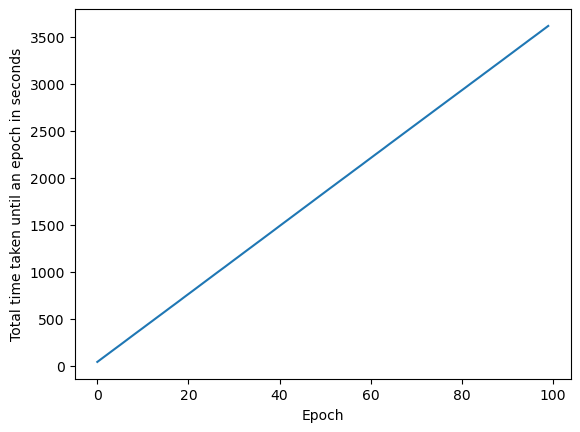

Epoch  0  run time is:  43.58480024400001
Epoch  1  run time is:  36.31549167799999
Epoch  2  run time is:  35.952515602999995
Epoch  3  run time is:  36.120458348000014
Epoch  4  run time is:  36.04519894800001
Epoch  5  run time is:  35.72486068800001
Epoch  6  run time is:  36.34433977499995
Epoch  7  run time is:  36.41857682599999
Epoch  8  run time is:  36.27444966600001
Epoch  9  run time is:  35.95786893300004
Epoch  10  run time is:  35.74582597699998
Epoch  11  run time is:  36.255779668
Epoch  12  run time is:  35.846087771999976
Epoch  13  run time is:  36.31800965900004
Epoch  14  run time is:  35.819339035999974
Epoch  15  run time is:  36.06561779100002
Epoch  16  run time is:  36.39759667999999
Epoch  17  run time is:  35.71777095799996
Epoch  18  run time is:  35.98069065100003
Epoch  19  run time is:  36.740418688999966
Epoch  20  run time is:  35.98630003900007
Epoch  21  run time is:  35.96872984999993
Epoch  22  run time is:  36.25410707200001
Epoch  23  run time i

In [11]:
#------------------------------------------------------------------------------
# TRAINING THE CNN ON THE TRAIN/VALIDATION DATA
#------------------------------------------------------------------------------

# initiate SGD optimizer
sgd = optimizers.SGD(lr=0.001, momentum=0.9)

# For a multi-class classification problem
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')


# initialize the number of epochs and batch size
EPOCHS = 100
BS = 128

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cumulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch, time.process_time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()
        from operator import itemgetter
        previous_time = 0
        for item in self.times:
            print("Epoch ", item[0], " run time is: ", item[1]-previous_time)
            previous_time = item[1]
        print("Total trained time is: ", previous_time)

timetaken = timecallback()
callbacks = [
    # This callback saves a SavedModel every epoch
    # We include the current epoch in the folder name.
    k.callbacks.ModelCheckpoint(
        filepath=os.path.join(os.getcwd(), "ckpt-{epoch}"), save_freq="epoch"
    ),
    timetaken
]


# train the model
history = model.fit(
    aug.flow(X_train,y_train_ohe, batch_size=BS),
    validation_data=(X_val,y_val),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS,
    callbacks=callbacks)

#We load the best weights saved by the ModelCheckpoint
#model.load_weights('/kaggle/working/weights.h5')

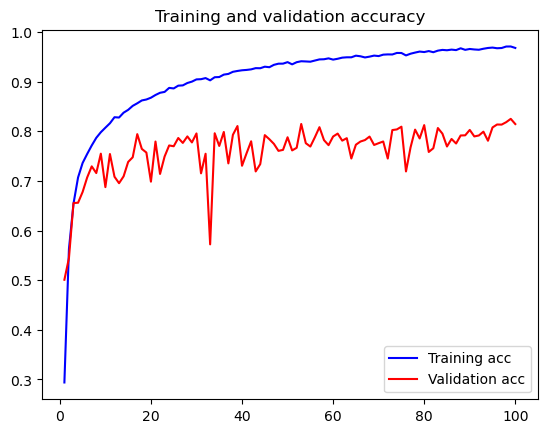

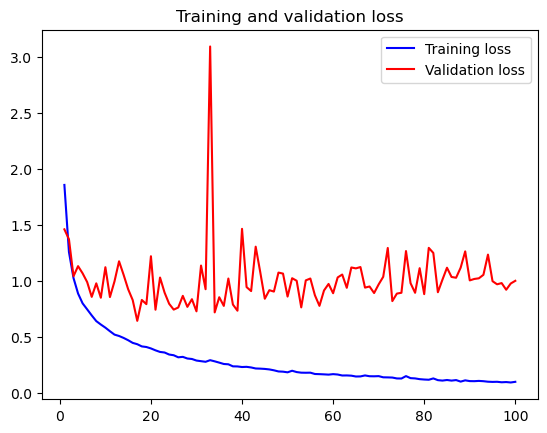

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
train_loss, train_accuracy = model.evaluate_generator(aug.flow(X_train,y_train_ohe, batch_size=BS), 156)
print('Training loss: {}\nTraining accuracy: {}'.format(train_loss, train_accuracy))

Training loss: 0.083481565117836
Training accuracy: 0.9731069803237915


In [14]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print('Validation loss: {}\nValidation accuracy: {}'.format(val_loss, val_accuracy))

313/313 [==============================] - 2s 7ms/step - loss: 1.0016 - accuracy: 0.8144
Validation loss: 1.0016255378723145
Validation accuracy: 0.8144000172615051


In [15]:
test_loss, test_accuracy = model.evaluate(X_test,y_test_ohe,)
print('Testing loss: {}\nTesting accuracy: {}'.format(test_loss, test_accuracy))

313/313 [==============================] - 2s 7ms/step - loss: 1.0687 - accuracy: 0.8051
Testing loss: 1.0686781406402588
Testing accuracy: 0.8051000237464905
